In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from sklearn.cluster import KMeans


# TP 2: Expectation-Maximisation algorithm – Importance sampling

# Exercise 1: Discrete distributions

1\. To generate $X$, we can:
* Let $U \sim \mathbb{U}([0,1])$ and $u$ a realisation of this uniform law.
* We compute the cumulated sums of the components of $(pi)_{i}$ and chose $$i_0 = min(\{k |  u \geq \sum_{i=1}^k p_i\} )$$ and sample: $$X = x_ {i_0}$$


Indeed, we have using the above method : $$\mathbb{P}(X = x_j) = \mathbb{P}(u \geq \sum_{i=1}^j p_i, u <\sum_{i=1}^{j+1} p_i  ) = p_j $$


In [22]:
def sample_sequence(probas, N=100):
    """ Sample indexes following probability input array

    Args:
        probas (ndarray): Array of probability to sample with
        N (int, optional): Number of samples. Defaults to 100.

    Returns:
        ndarray: sampled indexes
    """
    return np.searchsorted(np.cumsum(probas), np.random.rand(N))


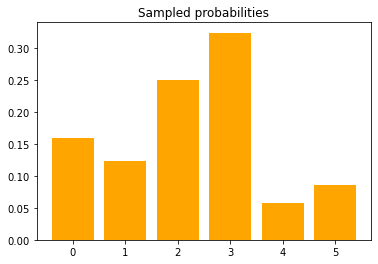

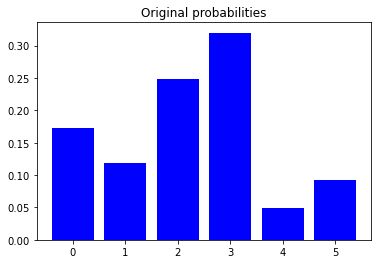

Squared norm of difference: 0.0003591522486505997


In [23]:
N = 1000
n_prob = 6

# Generate probability vector
probabilities = np.random.rand(6)
probabilities = probabilities/np.sum(probabilities)

# Sample and count
sampled = sample_sequence(probabilities,N)
exp_probabilities = np.bincount(sampled)/N


# Plot
plt.bar(range(n_prob), exp_probabilities, color = 'orange')
plt.title("Sampled probabilities")
plt.show()

plt.bar(range(n_prob), probabilities, color = "blue")
plt.title("Original probabilities")
plt.show()

print("Squared norm of difference:", np.sum((probabilities-exp_probabilities)**2))


---
---
---


# Exercice 2: Gaussian mixture model and the EM algorithm

$$\mathcal{L}(x_1, ..., x_n; \theta) = \prod_{i=1}^n \sum_{k=1}^m \alpha_k \frac{1}{\sqrt{(2\pi)^d|\Sigma_k|}} \exp ( - \frac{1}{2} (x_i - \mu_k)^t \Sigma_i^{-1} (x_i - \mu_k)  $$

### Question 2

In [24]:
m = 3
d = 2
n = 1000
alphas_true = np.random.rand(m)
alphas_true /= np.sum(alphas_true)

mus_true = np.array([[1, 4], [0, 0.5], [-3, -1]])
sigmas_true = np.array([
    [[1, 0.], [0., 0.1]],
    [[1, 0.4], [0.4, 1]],
    [[1, 0.4], [0.4, 1]],
])

In [25]:
def sample_gaussian_mixture(alphas, mus, sigmas, N=1000):
    """ samples from a gaussian mixture model

    Args:
        alphas: gaussian mixtures weights of shape m
        mus : means
        sigmas: covariance matrices
        N (int, optional): samples number. Defaults to 1000.
    Returns:
        ndarray: numpy array of samples of shape (N,m)
    """

    m = alphas.shape[0]
    samples_per_gaussian = np.bincount(np.searchsorted(np.cumsum(alphas), np.random.rand(N)), minlength=m)
    return np.concatenate([np.random.multivariate_normal(mus[i], sigmas[i], samples_per_gaussian[i]) for i in range(m)], axis=0)


def plot_samples(X, mus=None, title=None):
    plt.scatter(X[:, 0], X[:, 1], s=4)
    if mus is not None:
        plt.scatter(mus[:, 0], mus[:, 1])
    plt.title(title)


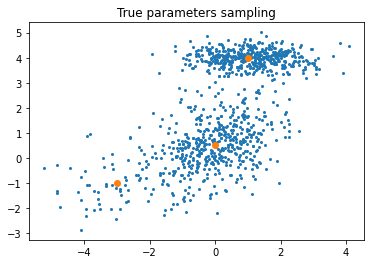

In [26]:
X_true = sample_gaussian_mixture(alphas_true, mus_true, sigmas_true)
plot_samples(X_true, mus=mus_true, title="True parameters sampling")


### Question 3

We have:

$$ Q(\theta | \theta_t)  =  \sum_{i = 1}^n \sum_{k = 1}^m \tau_{ik}^t( log(\alpha_j) + \frac{1}{2} log(|\Sigma_k^{-1}|) - \dfrac{1}{2} (x_i - \mu_k)^t \Sigma_k^{-1} (x_i - \mu_k)  + Cste) $$



At each step, $\forall k$ we update $\alpha_k$, $\mu_k$ and $\Sigma_k$  in order to maximize $Q(\theta| \theta_t)$ wrt to each variable.



1. Update $\alpha_k$: this is a feasible maximization problem under constraint ($\sum \alpha_k = 1$). We compute the Langrangian, find where it cancels, and with the contraint equality find the value of the lagrangian multiplicator.
This leads to $$\alpha_k^{t+1} = \frac{\sum_{i = 1}^n \tau_{ik}^t}{\sum_{i = 1}^n \sum_{k = 1}^m \tau_{ik}^t}$$

2. Update $\mu_k^{t+1}$: this is a quadratic fuction in $\mu_k$, we can compute the gradient wrt to $\mu_k$ and find where it is null, giving is the extrema.  This leads to (having $\Sigma$ non singular) $$ \mu_j^{t+1} = \frac{\sum_{i = 1}^n \tau_{ik}^t x_i}{\sum_{i = 1}^n \tau_{ik}^t}  $$

3. Update $\Sigma_k$: this is a concave function, the extreme is, the same way: $$ \Sigma_k^{t+1} = \dfrac{1}{\sum_{i = 1}^n \tau_{ik}^t} \sum_{i = 1}^n \tau_{ik}^t (x_i - \mu_k^t) (x_i - \mu_k^t)^t $$


(Transpose symbol and the indicator of the iteration notation conflict sometimes)

In [27]:
def log_likeihood_gm(X, alphas, mus, sigmas) -> float:
    """Computes the log-likelihood on gausian mixture model

    Args:
        X (ndarray): data
        alphas (ndarray): gaussian mixtures weights array
        mus (ndarray): means vectors array
        sigmas (ndarray): covariance matrices array

    Returns:
        float: log-likelihood value
    """
    return np.sum(np.log(np.sum(alphas*np.concatenate([multivariate_normal.pdf(
        X, mus[k], sigmas[k]).reshape(-1, 1) for k in range(alphas.shape[0])], axis=1), axis=1)))


def em_gaussian_mix(X, nb_iter=1000, m=3, return_ll=True):
    """ Performs EM algorithm for a gaussian mixture model

    Args:
        X (ndarray): data to estimate parameters from
        nb_iter (int, optional): Number of iterations to run EM algorithm. Defaults to 1000.
        return_ll (bool, optional): to return log_likelihood history over iterations. Defaults to True.

    """
    n, d = X.shape

    # Init estimators
    taus = np.zeros((n, m))
    alphas = np.ones(m)/m
    # mus = np.random.rand(m, d)
    mus = KMeans(n_clusters=m).fit(X).cluster_centers_
    sigmas = np.array([3 * np.eye(d) for i in range(m)])

    # Log likelihood history
    ll_list = []

    for iteration in range(nb_iter):
        # E-step
        for k in range(m):
            taus[:, k] = multivariate_normal.pdf(
                X, mus[k], sigmas[k])*alphas[k]
        taus /= np.sum(taus, axis=1)[:, np.newaxis]

        # M-step
        alphas = np.sum(taus, axis=0)/n
        for k in range(m):
            mus[k] = np.sum(X * taus[:, k][:, np.newaxis],
                            axis=0)/np.sum(taus[:, k])
            X_minus_muk = X - mus[k]
            sigmas[k] = X_minus_muk.T@(
                X_minus_muk*taus[:, k][:, np.newaxis])/np.sum(taus[:, k])

        # Log likelihood
        ll_list.append(log_likeihood_gm(X, alphas, mus, sigmas))

    return alphas, mus, sigmas, ll_list


Text(0.5, 1.0, 'Log-likelihood over the iterations')

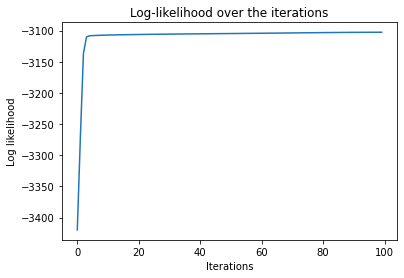

In [28]:
alphas_estim, mus_estim, sigmas_estim, ll_list = em_gaussian_mix(X_true, nb_iter=100)

plt.plot(range(len(ll_list)), ll_list)
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")
plt.title("Log-likelihood over the iterations")

Text(0.5, 1.0, 'Compared samplings estimated vs true')

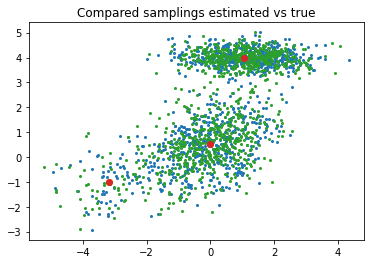

In [29]:
X_estim = sample_gaussian_mixture(
    alphas_estim, mus_estim, sigmas_estim, N=1000)
plot_samples(X_estim, mus=mus_estim)
plot_samples(X_true, mus=mus_estim)
plt.title("Compared samplings estimated vs true")

### Question 4

From the above observations, the obtained parameters seem to be close to the original ones.

### Question 5

Let's download and prepare the data

In [30]:
!wget -nv -nc "https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_Period_Indicators_Medium.csv"
print()

Visualize the points

In [31]:
BIRTH_DEATH_PATH = "WPP2019_Period_Indicators_Medium.csv"

# Load data
pd_death_birth = pd.read_csv(BIRTH_DEATH_PATH)
pd_death_birth.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,TFR,NRR,CBR,Births,...,CDR,Deaths,DeathsMale,DeathsFemale,CNMR,NetMigrations,GrowthRate,NatIncr,SRB,MAC
0,4,Afghanistan,2,Medium,1950-1955,1953,7.45,1.636,50.314,2015.476,...,36.862,1476.605,794.020,682.585,-0.499,-20.0,1.296,13.452,1.06,29.835
1,4,Afghanistan,2,Medium,1955-1960,1958,7.45,1.765,50.998,2201.589,...,33.718,1455.605,783.110,672.495,-0.463,-20.0,1.683,17.280,1.06,29.835
2,4,Afghanistan,2,Medium,1960-1965,1963,7.45,1.899,51.477,2439.130,...,30.808,1459.784,777.437,682.347,-0.422,-20.0,2.026,20.669,1.06,29.835
3,4,Afghanistan,2,Medium,1965-1970,1968,7.45,2.017,51.646,2728.221,...,28.223,1490.896,790.745,700.151,-0.379,-20.0,2.307,23.423,1.06,29.835
4,4,Afghanistan,2,Medium,1970-1975,1973,7.45,2.141,51.234,3056.451,...,25.495,1520.938,802.414,718.524,-0.335,-20.0,2.544,25.739,1.06,29.835


Text(0, 0.5, 'Crude death rate')

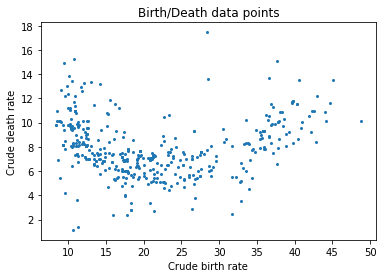

In [32]:
# Select relevant data (2010-2015 period) and convert
X_bd = pd_death_birth.loc[pd_death_birth['Time'] == "2010-2015"][["CBR", "CDR"]].dropna().to_numpy()
plot_samples(X_bd, title="Birth/Death data points")
plt.xlabel("Crude birth rate")
plt.ylabel("Crude death rate")

On the above plot, we can see that the data seems to be distributed in several distinct aggregates, thus it seems reasonable to try to modelize this distribution by a gaussian mixture (of 3 or 4 gaussian units maybe)

### Question 6

In [33]:
def bic_gm(X, alphas, mus, sigmas):
    """ Computes Bayesian Information Criterion for given parameters
    """
    m = alphas.shape[0]
    n,d = X.shape
    # For each gaussian, we estimate a weight, the mean coefficients, the covariance coefficents
    df = m*(1 + d + d**2)

    return -log_likeihood_gm(X, alphas, mus, sigmas) + 0.5*(df)*np.log(n)

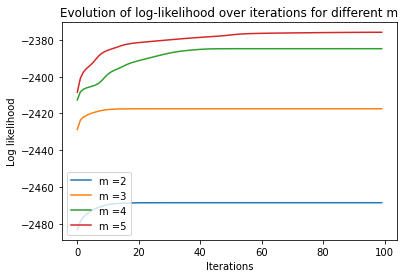

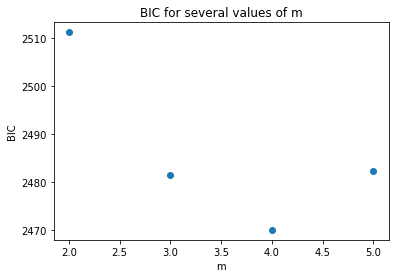

In [34]:
MAX_M = 5
bics = []
results = []

# Apply EM for several values of m
for m in range(2, MAX_M +1):
    results.append( (m,*em_gaussian_mix(X_bd, nb_iter=100, m = m)))


# Plot log-likelihood evolutions
for i in range(len(results)):	
    m, alphas_bd, mus_bd, sigmas_bd, ll_list_bd = results[i]
    plt.plot(range(len(ll_list_bd)),ll_list_bd, label = "m =" + str(m))

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")
plt.title("Evolution of log-likelihood over iterations for different m")
plt.show()

# Plot BIC
plt.scatter( [r[0] for r in results], [bic_gm(X_bd, r[1], r[2], r[3]) for r in results])
plt.xlabel("m")
plt.ylabel("BIC")
plt.title("BIC for several values of m")
plt.show()


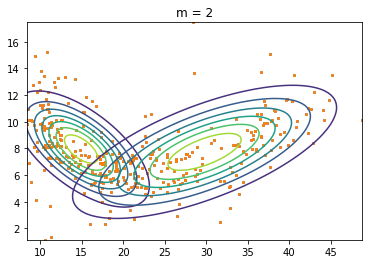

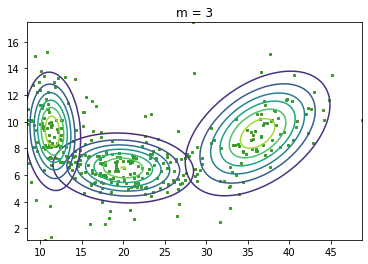

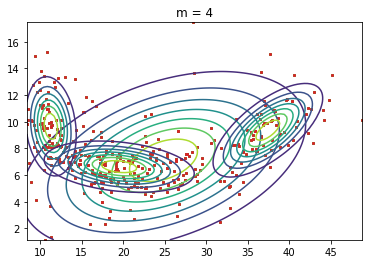

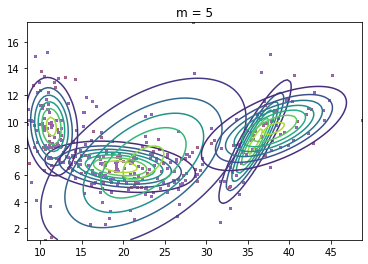

In [35]:

# Plots contour lines for estimated gaussian, for multiple values of m
n_grid = 100
XX, YY  = np.meshgrid(np.linspace(np.min(X_bd[:,0]),np.max(X_bd[:,0]), n_grid), np.linspace(np.min(X_bd[:,1]),np.max(X_bd[:,1]), n_grid) )
data_temp= np.concatenate((XX.reshape((-1,1)), YY.reshape((-1,1))), axis = 1 )
# Run through results
for i in range(len(results)):
    m, alphas_bd, mus_bd, sigmas_bd, ll_list_bd = results[i]
    for i in range(m):
        plot_samples(X_bd)
        Z = multivariate_normal.pdf(data_temp, mus_bd[i], sigmas_bd[i]).reshape(XX.shape)
        plt.contour(XX, YY, Z)
    plt.title("m = "+ str(m))
    plt.show()

The estimation for m=3 seem to distinguish 3 global trends. Notably, among those, we have countries with higher birth rate than death rate, they are probably developing countries. On the opposite, countries with higher death rate are probably developped countries, where natality drops.

---
---
---


# Exercise 3: Importance samplig

## 3.A Poor importance sampling
### Question 1

In [36]:
def f(x):
    return 2*np.sin(np.pi*x/1.5)
def p(x):
    return x**0.65*np.exp(-x**2/2)
def q(x, mu):
    return np.exp(-(mu-x)**2/3.)*2/np.sqrt(2*np.pi*1.5)

def poor_imp_sampling(N, mu):
    samples = []
    weights = []
    while len(weights) < N:
        x = np.random.normal(loc = mu, scale = 1.5)
        if x > 0:
            weights.append(p(x)/q(x, mu= mu))
            samples.append(x)
    return np.mean(np.array([weights[i]*f(samples[i]) for i in range(N)])/np.mean(weights))


### Question 2

In [37]:

for N in [10,100, 1000, 10000]:
    estimations = [poor_imp_sampling(N, mu = 0.8) for i in range(10) ]
    print("N = " + str(N), " estimation:", np.mean(estimations))

N = 10  estimation: 0.541095111092796
N = 100  estimation: 0.6340998317640848
N = 1000  estimation: 0.6882919931216938
N = 10000  estimation: 0.6858861280538638


### Question 3

In [38]:

for N in [10,100, 1000, 10000]:
    estimations = [poor_imp_sampling(N, mu = 6.) for i in range(10) ]
    print("N = " + str(N), " estimation:", np.mean(estimations))

N = 10  estimation: 0.7251608500041338
N = 100  estimation: -0.6352945512359136
N = 1000  estimation: -0.5187957791623864
N = 10000  estimation: 1.0178069419316034


## 3.B Adaptative Importance Sampling

### Question 4.

We need to optimize the log-llikelihood of the exercise 2 where every log is weighted by the normalized weights.
Thus we can apply the principle of EM algorithm but with weighted $\tau_{ik}$, ie maximizing at each step:

$$ Q(\theta | \theta_t)  =  \sum_{i = 1}^n \sum_{k = 1}^m \tilde{\omega_i} \tau_{ik}^t( log(\alpha_j) + \frac{1}{2} log(|\Sigma_k^{-1}|) - \dfrac{1}{2} (x_i - \mu_k)^t \Sigma_k^{-1} (x_i - \mu_k)  + Cste)$$


The parameters update is the same but we have a new $\tau_{ik}$ equivalent which is $\omega_i \tau_{ik}$


## 3.C Application to a banana-shaped density

### Question 5.

Note: the algorithm below is quite unstable, I did not have time to fix those computing errors, which lead to exploding values for some banana parameters sometimes.

In [39]:
def PMC(b, sigma_ban, m, nb_iter = 10, plot_intermediate_2d = False):
    d = 5
    n = 10000

    # Init parameters
    alphas = np.ones(m)/m
    # mus = np.random.rand(m, d)
    sigmas = np.array([3 * np.eye(d) for i in range(m)])

    mus= np.random.rand(m,d)

    taus = np.zeros((n, m))

    for iteration_pmc in range(nb_iter):

        # Sample gaussian mixture, apply gaussian density, apply banana density, compute weights
        X_gauss = sample_gaussian_mixture(alphas, mus, sigmas, n)
        X_gauss_banana = X_gauss.copy()
        X_gauss_banana[:,1] = X_gauss_banana[:,1] + b*(X_gauss_banana[:,0]**2 - sigma_ban**2)

        p_val = multivariate_normal.pdf(X_gauss_banana, np.zeros(d), np.concatenate( ([ sigma_ban**2], np.ones(d-1))) ) 
        q_val = np.sum([alphas[k]*multivariate_normal.pdf(X_gauss, mus[k], sigmas[k]) for k in range(m)], axis = 0) 

        weights = p_val/q_val
        weights = weights/np.mean(weights)


        # Alternative EM
        nb_iter_em = 100
        for iteration in range(nb_iter_em):

            # E-step
            for k in range(m):
                taus[:, k] = multivariate_normal.pdf(
                    X_gauss, mus[k], sigmas[k])*alphas[k]
            taus /= np.sum(taus, axis=1)[:, np.newaxis]

            # M-step
            taus_bis = taus*weights[:, np.newaxis]
            alphas = np.sum(taus_bis, axis=0)/np.sum(taus_bis)
            alphas = alphas + 10e-4*np.ones(m)
            alphas/= np.sum(alphas)

            for k in range(m):
                mus[k] = np.sum(X_gauss * taus_bis[:, k][:, np.newaxis], axis=0)/np.sum(taus_bis[:, k])
                X_minus_muk = X_gauss - mus[k]
                sigmas[k] = X_minus_muk.T@(X_minus_muk*taus_bis[:, k][:, np.newaxis])/np.sum(taus_bis[:, k])  + 10e-8*np.eye(d)

        if plot_intermediate_2d:
            plot_samples(sample_gaussian_mixture(alphas, mus, sigmas, 10000))
            plt.show()


    return alphas, mus, sigmas



alphas, mus, sigmas = PMC(0.9, 1. ,m=3, nb_iter = 5, plot_intermediate_2d=False)
# print(alphas,mus,sigmas)

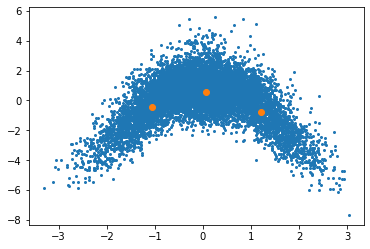

In [40]:
plot_samples(sample_gaussian_mixture(alphas, mus, sigmas, 10000) , mus = mus)
plt.show()